# COVID-19 Cell Annotation Pipeline

## Overview
This notebook performs comprehensive cell type annotation and quantification for COVID-19 lung scRNA-seq data using:
1. **CellTypist** automated annotation
2. **Marker gene validation**
3. **Manual curation**
4. **Cell-type composition analysis**

## Key Steps

1. **Data Loading**
   - Loaded clustered AnnData object (`clustered.h5ad`)
   - Set global seed for reproducibility

2. **Automated Annotation (CellTypist)**
   - Used `Immune_All_Low.pkl` model
   - Added labels to `adata.obs['celltypist_labels']`

3. **Cluster-Level Assignment**
   - Assigned dominant cell type per Leiden cluster
   - Visualized UMAP with predicted and Leiden labels

4. **Marker-Based Validation**
   - Cross-referenced top 5 marker genes per cluster
   - Validated annotations with known marker databases

5. **Manual Curation**
   - Auto-filled clear markers (e.g., COL1A1 → Fibroblasts)
   - Manually resolved ambiguous clusters
   - Finalized `adata.obs['final_celltype']` for 10 major types

6. **Cell Type Composition Analysis**
   - Calculated per-condition fractions (COVID vs Control)
   - Created grouped bar plots and per-sample boxplots
   - Identified significantly enriched populations (e.g., macrophages ↑ in COVID)

7. **Visualization & Output**
   - UMAPs, barplots, boxplots saved to `/figures`
   - Annotated object saved as `clustered_final_celltypes.h5ad`

## Output Files
- `clustered_final_celltypes.h5ad`: Final annotated dataset
- `merged_table_celltype_annotations.csv`: Cluster–marker–label map
- `barplot_celltype_fractions.png`: Global cell type proportions
- `boxplot_celltype_fractions_by_sample.png`: Per-sample cell type variation

In [110]:
# Load important packages
import scanpy as sc
import celltypist
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

#Set seed for reproducibility
random.seed(42)
np.random.seed(42)

In [10]:
from celltypist import models

# Download Immune model
models.download_models(model='Immune_All_Low.pkl')

📂 Storing models in C:\Users\oluwa\.celltypist\data\models
💾 Total models to download: 1
⏩ Skipping [1/1]: Immune_All_Low.pkl (file exists)


In [4]:
# Load clustered AnnData object
adata = sc.read("clustered.h5ad")

### Utilising the CellTypist Models for cell annotation
##### PURPOSE:
- Using CellTypist’s pretrained Immune and the Epithelial model to assign cell type labels to each nucleus
- CellTypist uses logistic regression over known reference expression signatures
- `majority_voting=True` applies smoothing based on neighbors (via precomputed clustering/UMAP)

In [12]:
# Step 1: Annotate Cells with CellTypist
results = celltypist.annotate(
    adata,
    model='Immune_All_Low.pkl', 
    majority_voting=True
)

👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will use `.raw.X` instead
🔬 Input data has 65217 cells and 31753 genes
🔗 Matching reference genes in the model
🧬 5997 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


CellTypist used the pretrained Immune_All_Low model to predict cell types for each of your 65,217 cells based on expression profiles.
It automatically switched to .raw.X for normalized data and used ~6,000 overlapping genes for logistic regression.
With majority_voting=True, it smoothed predictions using neighborhood information to reduce noise and finalize labels.

In [17]:
dir(results)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'adata',
 'cell_count',
 'decision_matrix',
 'predicted_labels',
 'probability_matrix',
 'summary_frequency',
 'to_adata',
 'to_plots',
 'to_table']

In [18]:
results.adata.obs.columns

Index(['sample', 'condition', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet',
       'leiden', 'log1p_total_counts', 'log1p_n_genes_by_counts',
       'celltypist_labels'],
      dtype='object')

In [19]:
# Step 2: Add the predicted Labels to the AnnData
adata.obs['celltypist_labels'] = results.adata.obs['celltypist_labels']

In [21]:
#Verify the addition. View a few annotated cells
adata.obs[['leiden', 'celltypist_labels']].head(10)

,leiden,celltypist_labels
TAGGTACCATGGCCAC-1_1,17,Plasma cells
ATTCACTGTAACAGGC-1_1,17,Plasma cells
TAACTTCCAACCACGC-1_1,15,Alveolar macrophages
TTGGGTACACGACAAG-1_1,17,Plasma cells
AGGCCACAGAGTCACG-1_1,17,GMP
CACTGAAGTCGAAGCA-1_1,17,Plasma cells
ACTGATGTCTGCACCT-1_1,2,Epithelial cells
TTACCGCCACTCAGAT-1_1,17,Plasma cells
TTGGTTTTCCTAGCTC-1_1,15,Alveolar macrophages
TGGGAAGTCAGTGATC-1_1,17,Late erythroid


In [22]:
# Count how many cells per predicted cell type
adata.obs['celltypist_labels'].value_counts()

celltypist_labels
Alveolar macrophages        12409
Epithelial cells             8215
Plasma cells                 7644
Fibroblasts                  6017
Tcm/Naive helper T cells     5607
                            ...  
Granulocytes                    1
ELP                             1
Pro-B cells                     1
Mono-mac                        1
Pre-pro-B cells                 1
Name: count, Length: 81, dtype: int64

In [23]:
#Step 3: Save Annotated Object
adata.write("celltyped.h5ad")

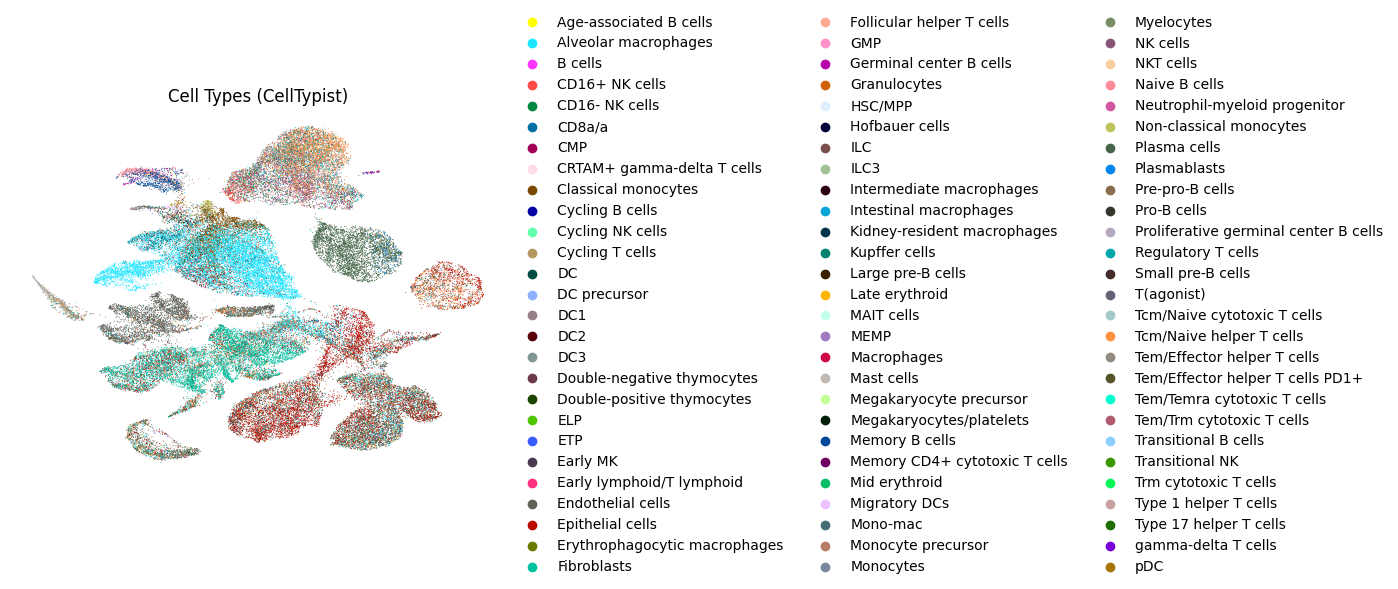

In [25]:
# Step 4: UMAP colored by CellTypist-predicted cell types

sc.pl.umap(
    adata,
    color='celltypist_labels',
    legend_loc='right margin',     
    title='Cell Types (CellTypist)',
    frameon=False,
    save='_celltypist_umap.png'   
)

In [28]:
# To identify clusters based on dominant cell type per Leiden cluster
cluster_celltypes = (
    adata.obs
    .groupby('leiden')['celltypist_labels']
    .agg(lambda x: pd.Series(x).value_counts().idxmax())  # Pick most frequent label
    .reset_index()
    .rename(columns={'celltypist_labels': 'dominant_cell_type'})  # Rename column
)

In [29]:
# Convert the cluster summary table into a mapping dictionary based on leiden clustering
cluster_to_label = dict(zip(cluster_celltypes['leiden'], cluster_celltypes['dominant_cell_type']))

# Add new column: dominant cell type per Leiden cluster
adata.obs['dominant_cell_type'] = adata.obs['leiden'].map(cluster_to_label)

... storing 'dominant_cell_type' as categorical


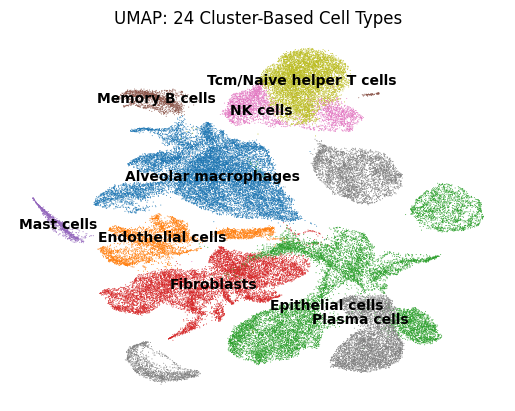

In [30]:
# Plot UMAP where each cluster is labeled by its dominant cell type
sc.pl.umap(
    adata,
    color='dominant_cell_type',
    legend_loc='on data',
    title='UMAP: 24 Cluster-Based Cell Types',
    frameon=False,
    save='_leiden_dominant_celltype.png'
)


### Cross-Validation of Cell Type Annotations

To ensure robust and biologically accurate cell type annotation of the 24 Leiden clusters in our COVID-19 lung scRNA-seq dataset, we performed a cross-validation using three complementary approaches:

#### 1. **Supervised Prediction with CellTypist**
- We used a pretrained **immune + epithelial model** from CellTypist to predict 81 detailed immune and epithelial cell types.
- These predictions were added to the AnnData object under `adata.obs['celltypist_labels']`.

#### 2. **Cluster-Level Consensus: Dominant Cell Type per Leiden Cluster**
- Since some predicted labels were too granular or rare, we summarized the annotation by assigning each Leiden cluster its **most frequent CellTypist-predicted label**, recorded in `adata.obs['dominant_cell_type']`.
- This resulted in a cleaner, interpretable annotation with ~9–10 biologically plausible cell types across the 24 clusters.

#### 3. **Cross-Validation with Top Marker Genes**
- Independently, we performed differential expression analysis to identify the **top-ranked marker genes** per Leiden cluster using statistical metrics (e.g., log fold change, p-values, detection percentages).
- These markers were compared with known canonical genes from literature and databases (e.g., PTPRC for T cells, MRC1 for macrophages, EPCAM for epithelial cells).
- By cross-matching dominant cell type predictions with cluster-specific marker gene expression, we validated the consistency of automated annotations and flagged potential mismatches for manual review.

#### Interpretation
- Agreement between **CellTypist predictions** and **differentially expressed markers** increases confidence in the assigned cell identities.
- This hybrid approach balances data-driven predictions with biological interpretability, forming the basis for curated final cluster labels.


In [39]:
#Step 1: Load the Top Marker Gene Table
marker_df = pd.read_csv("C:/Users/oluwa/Desktop/covid-lung-scrna-python/clustered/top5_marker_genes_per_cluster.csv")

In [40]:
# Preview
marker_df.head()

,cluster,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,0,PTPRC,94.155200,4.004817,0.0,0.0,0.831567,0.267032
1,0,SKAP1,90.651794,5.442446,0.0,0.0,0.718019,0.071627
2,0,PARP8,90.165565,4.182425,0.0,0.0,0.765500,0.248260
3,0,ARHGAP15,89.638756,3.910859,0.0,0.0,0.799187,0.256952
4,0,FYN,86.857770,4.320937,0.0,0.0,0.743284,0.169844


In [42]:
print(marker_df.columns)

Index(['cluster', 'names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj',
       'pct_nz_group', 'pct_nz_reference'],
      dtype='object')


In [60]:
cluster_celltypes

,leiden,dominant_cell_type
0,0,Tcm/Naive helper T cells
1,1,Alveolar macrophages
2,2,Epithelial cells
3,3,Fibroblasts
4,4,Alveolar macrophages
5,5,Fibroblasts
6,6,Plasma cells
7,7,Plasma cells
8,8,Epithelial cells
9,9,Endothelial cells


In [43]:
#Step 2: Compare with CellTypist-Derived Cluster Labels
# Merge top markers with dominant cell type labels
marker_df['cluster'] = marker_df['cluster'].astype(int)
cluster_celltypes['leiden'] = cluster_celltypes['leiden'].astype(int)

In [44]:
# Merge on correct column names
merged = marker_df.merge(cluster_celltypes, left_on='cluster', right_on='leiden')

In [51]:
#Step 3: Group by cluster and aggregate marker genes + dominant cell type
merged_table = (
    merged.groupby('leiden')
    .agg({
        'names': lambda genes: ', '.join(genes),
        'dominant_cell_type': 'first'
    })
    .reset_index()
    .rename(columns={'names': 'top5_marker_genes'})
)

In [52]:
#Step 4: Show result
merged_table.head(24)

,leiden,top5_marker_genes,dominant_cell_type
0,0,"PTPRC, SKAP1, PARP8, ARHGAP15, FYN",Tcm/Naive helper T cells
1,1,"SLC8A1, ZEB2, DPYD, CTSB, DMXL2",Alveolar macrophages
2,2,"NCKAP5, EMP2, LMO7, KHDRBS2, LIMCH1",Epithelial cells
3,3,"ROBO2, PRKG1, LAMA2, SLIT2, LSAMP",Fibroblasts
4,4,"CTSD, PSAP, FTL, CTSB, FTH1",Alveolar macrophages
5,5,"COL6A3, COL1A2, COL3A1, DCN, COL1A1",Fibroblasts
6,6,"SFTPB, ZNF385B, LRRK2, ANK3, PDE4D",Plasma cells
7,7,"FBXW7, TXNDC5, IFNG-AS1, FNDC3B, ST6GAL1",Plasma cells
8,8,"SFTPB, MACROD2, NEAT1, SLC34A2, LMO3",Epithelial cells
9,9,"LDB2, EPAS1, ADGRL2, TCF4, DOCK9",Endothelial cells


In [54]:
# Step 5: Save result.
merged_table.to_csv(
    "C:/Users/oluwa/Desktop/covid-lung-scrna-python/clustered/merged_table_celltype_annotations.csv",
    index=False
)

In [84]:
# Step 6: Reload the merged table into a new DataFrame
review_table = pd.read_csv("C:/Users/oluwa/Desktop/covid-lung-scrna-python/clustered/merged_table_celltype_annotations.csv")

In [85]:
#Preview the data
review_table

,leiden,top5_marker_genes,dominant_cell_type
0,0,"PTPRC, SKAP1, PARP8, ARHGAP15, FYN",Tcm/Naive helper T cells
1,1,"SLC8A1, ZEB2, DPYD, CTSB, DMXL2",Alveolar macrophages
2,2,"NCKAP5, EMP2, LMO7, KHDRBS2, LIMCH1",Epithelial cells
3,3,"ROBO2, PRKG1, LAMA2, SLIT2, LSAMP",Fibroblasts
4,4,"CTSD, PSAP, FTL, CTSB, FTH1",Alveolar macrophages
5,5,"COL6A3, COL1A2, COL3A1, DCN, COL1A1",Fibroblasts
6,6,"SFTPB, ZNF385B, LRRK2, ANK3, PDE4D",Plasma cells
7,7,"FBXW7, TXNDC5, IFNG-AS1, FNDC3B, ST6GAL1",Plasma cells
8,8,"SFTPB, MACROD2, NEAT1, SLC34A2, LMO3",Epithelial cells
9,9,"LDB2, EPAS1, ADGRL2, TCF4, DOCK9",Endothelial cells


In [86]:
#Step 7: Auto-curate Obvious Matches:To automatically assign a meaningful and biologically accurate final label to each 
#Leiden cluster, but only when the top marker genes and CellTypist prediction strongly agree.
#This reduces manual annotation effort and builds confidence in downstream analyses.
# Define a function that takes one row of the DataFrame
def auto_curate(row):
    genes = row['top5_marker_genes']
    prediction = row['dominant_cell_type'].lower()

    if any(g in genes for g in ['CD14', 'LYZ', 'MRC1']) and 'macrophage' in prediction:
        return 'Alveolar macrophages'

    if 'EPCAM' in genes:
        return 'Epithelial cells'

    if 'PTPRC' in genes and 't cell' in prediction:
        return 'Naive T cells'

    return np.nan

review_table['final_label'] = review_table.apply(auto_curate, axis=1)

In [87]:
#Step 8: Map auto-curated labels into adata.obs
adata.obs['leiden_int'] = adata.obs['leiden'].astype(int)

# Assign auto-curated values first
adata.obs['final_celltype'] = adata.obs['leiden_int'].map(
    dict(zip(review_table['leiden'], review_table['final_label']))
)

#### Manual Adjustment of Cluster Labels
After automated annotation using CellTypist and differential gene expression analysis, we manually curated cell type labels for ambiguous clusters.
This manual adjustment was based on:
- Top 5 marker genes per cluster from DE analysis
- Dominant CellTypist-predicted labels
- Canonical markers from literature, PanglaoDB, and the Human Lung Cell Atlas

We matched each cluster to a biologically plausible cell identity using a combination of these factors. Below is the final curated mapping with justification via representative marker genes:

In [88]:
#Step 9: Fill missing labels with your manual assignment
manual_labels = {
    1: "Alveolar macrophages", 2: "Epithelial cells", 3: "Fibroblasts", 4: "Alveolar macrophages",
    5: "Fibroblasts", 6: "Plasma cells", 7: "Plasma cells", 8: "Epithelial cells",
    9: "Endothelial cells", 11: "NK cells", 12: "Epithelial cells", 13: "Epithelial cells",
    14: "Plasma cells", 16: "Memory B cells", 17: "Plasma cells", 18: "Epithelial cells",
    19: "NK cells", 20: "Endothelial cells", 21: "Mast cells", 22: "Fibroblasts",
    23: "Smooth muscle cells"
}

# Fill missing only where auto-curate didn't work
adata.obs['final_celltype'] = adata.obs.apply(
    lambda row: manual_labels.get(row['leiden_int'], row['final_celltype']),
    axis=1
)

In [89]:
# Cross-Check if all 24 clusters are labeled now
adata.obs[['leiden', 'final_celltype']].drop_duplicates().sort_values('leiden')

,leiden,final_celltype
TCCGGGAAGGCACAAC-1_1,0,Naive T cells
TTGGATGGTGTCCGGT-1_1,1,Alveolar macrophages
ACTGATGTCTGCACCT-1_1,2,Epithelial cells
TCCACCACACAATGCT-1_1,3,Fibroblasts
TCCCATGGTCTACATG-1_1,4,Alveolar macrophages
CAACAGTCAGCATCTA-1_1,5,Fibroblasts
AAGTTCGCAACACGTT-1_1,6,Plasma cells
TTCATGTCAACAGATA-1_1,7,Plasma cells
GGAGGTAGTGAAGCGT-1_1,8,Epithelial cells
CCACGAGTCTCTTAAC-1_1,9,Endothelial cells


... storing 'final_celltype' as categorical


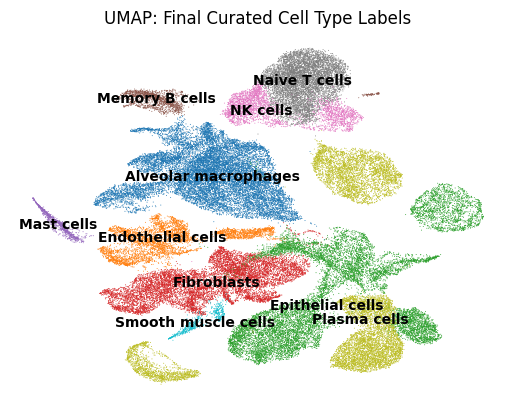

In [90]:
#Visualize the final cell type annotations on UMAP (UMAP aggregate cell annotation. Roughly 10 clusters)
sc.pl.umap(
    adata,
    color='final_celltype',
    legend_loc='on data',
    title='UMAP: Final Curated Cell Type Labels',
    frameon=False,
    save='_final_celltype_labels.png'
)

In [91]:
adata.obs['final_celltype'].nunique()

10

In [96]:
#Step 10: To assign complete cell name to the 24 clusters
#Update the manual_labels dictionary to include all 24 clusters (0–23):
manual_labels = {
    0: "Naive T cells",              # PTPRC, SKAP1
    1: "Alveolar macrophages",       # CTSB, DMXL2
    2: "Epithelial cells",           # EMP2, KHDRBS2
    3: "Fibroblasts",                # ROBO2, PRKG1
    4: "Alveolar macrophages",       # CTSB, FTH1
    5: "Fibroblasts",                # COL6A3, COL1A1
    6: "Plasma cells",               # SFTPB, PDE4D
    7: "Plasma cells",               # IFNG-AS1, FNDC3B
    8: "Epithelial cells",           # SFTPB, LMO3
    9: "Endothelial cells",          # EPAS1, DOCK9
    10: "Alveolar macrophages",      # MRC1, SLC8A1
    11: "NK cells",                  # PTPRC, CD247
    12: "Epithelial cells",          # SFTPB, SGMS2
    13: "Epithelial cells",          # PTPRN2
    14: "Plasma cells",              # PDE4D, ZNF385B
    15: "Alveolar macrophages",      # PPARG, MRC1
    16: "Memory B cells",            # BANK1, PRKCB
    17: "Plasma cells",              # CFAP299, DNAH12
    18: "Epithelial cells",          # MECOM, ALCAM
    19: "NK cells",                  # PTPRC, PRKCH
    20: "Endothelial cells",         # LDB2, KALRN
    21: "Mast cells",                # KIT, IL18R1
    22: "Fibroblasts",               # COL6A3, COL1A1
    23: "Smooth muscle cells",       # CALD1, PRKG1
}

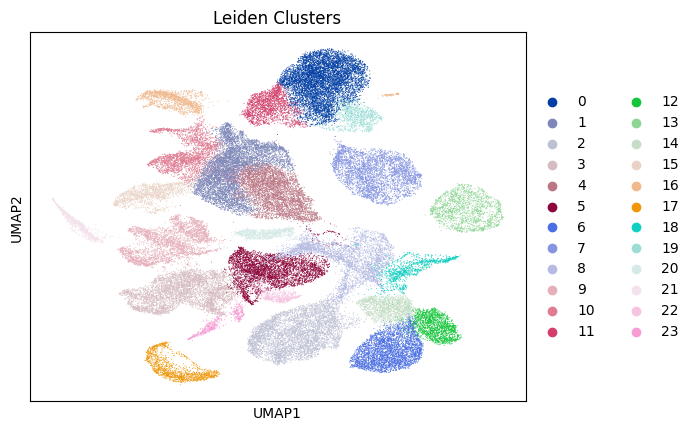

In [92]:
# To visualse the complete 24 clusters
sc.pl.umap(adata, color='leiden', title='Leiden Clusters')

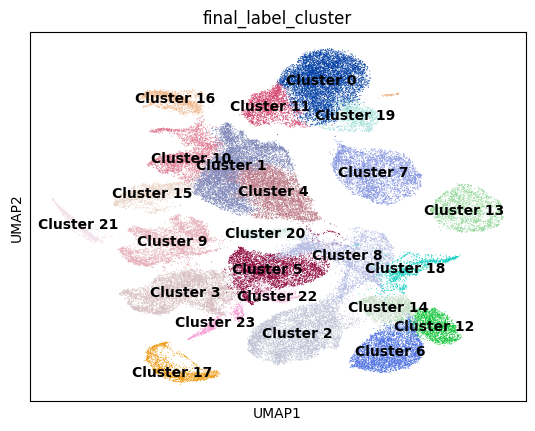

In [93]:
adata.obs['final_label_cluster'] = adata.obs['leiden'].apply(lambda x: f"Cluster {x}")
sc.pl.umap(adata, color='final_label_cluster', legend_loc='on data')

... storing 'annotated_cluster' as categorical


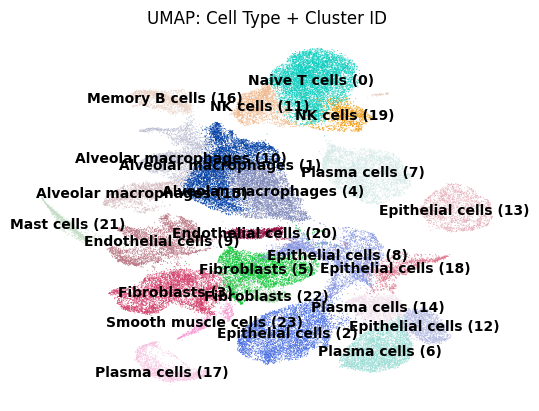

In [100]:
# Annotate cluster with cell type + ID (Completely optional)
adata.obs['annotated_cluster'] = adata.obs['leiden_int'].apply(
    lambda x: f"{adata.obs.loc[adata.obs['leiden_int'] == x, 'final_celltype'].iloc[0]} ({x})"
)

sc.pl.umap(
    adata,
    color='annotated_cluster',
    legend_loc='on data',
    title='UMAP: Cell Type + Cluster ID',
    frameon=False,
    save='_annotated_clusters.png'
)
# Optional plot to purposely overlay the actually cluster names

In [103]:
#Save data
adata.write("clustered_final_celltypes.h5ad")

### Cell Type Fractions by Condition
The Goal is to determine whether specific cell types like macrophages or epithelial cells are enriched or depleted in COVID-19 vs control lungs.
This helps to validate the annotation and discover disease-relevant populations. This also helps to Focus **DEGs on specific cell types**

In [104]:
#Step 1: Verify Required Columns. To ensure the AnnData object contains the labels and conditions:
# View columns in your AnnData object
print(adata.obs.columns)

Index(['sample', 'condition', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet',
       'leiden', 'log1p_total_counts', 'log1p_n_genes_by_counts',
       'celltypist_labels', 'dominant_cell_type', 'final_celltype',
       'leiden_int', 'final_label_cluster', 'cluster_celltype_label',
       'annotated_cluster'],
      dtype='object')


In [105]:
# Preview the relevant data
adata.obs[['final_celltype', 'condition']].dropna().head()

,final_celltype,condition
TAGGTACCATGGCCAC-1_1,Plasma cells,Control
ATTCACTGTAACAGGC-1_1,Plasma cells,Control
TAACTTCCAACCACGC-1_1,Alveolar macrophages,Control
TTGGGTACACGACAAG-1_1,Plasma cells,Control
AGGCCACAGAGTCACG-1_1,Plasma cells,Control


In [106]:
#Step 2: Count Cell Types per Condition
# Count number of cells per (condition × cell type)
counts = (
    adata.obs
    .groupby(['condition', 'final_celltype'])
    .size()
    .unstack(fill_value=0)
)

In [107]:
# View raw counts table
counts.T

condition,COVID,Control
final_celltype,,
Alveolar macrophages,10512,4471
Endothelial cells,1792,2507
Epithelial cells,4167,9127
Fibroblasts,4638,4689
Mast cells,355,566
Memory B cells,260,1244
NK cells,2083,885
Naive T cells,3247,3640
Plasma cells,3224,7204


In [111]:
#Step 3: Normalize Counts to Fractions
fractions = counts.div(counts.sum(axis=1), axis=0)
fractions.T  # View as transposed for readability
#This gives the relative proportion of each cell type within each condition. 

condition,COVID,Control
final_celltype,,
Alveolar macrophages,0.345176,0.128614
Endothelial cells,0.058843,0.072117
Epithelial cells,0.136829,0.262549
Fibroblasts,0.152295,0.134885
Mast cells,0.011657,0.016282
Memory B cells,0.008537,0.035785
NK cells,0.068398,0.025458
Naive T cells,0.106620,0.104709
Plasma cells,0.105865,0.207232


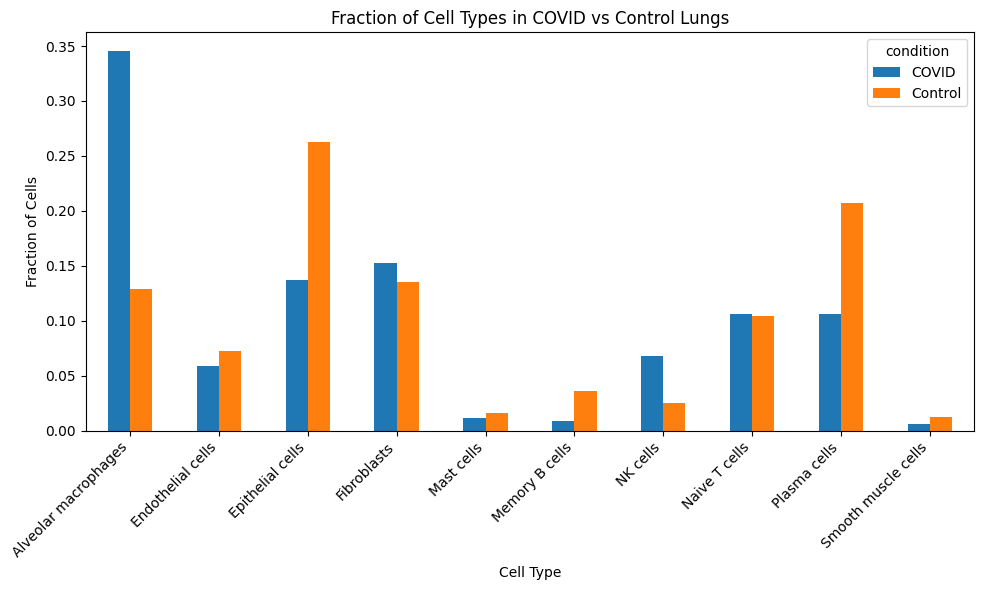

In [125]:
#Step 4: Visualize as Barplot
ax = fractions.T.plot(kind='bar', figsize=(10, 6))
plt.title("Fraction of Cell Types in COVID vs Control Lungs")
plt.ylabel("Fraction of Cells")
plt.xlabel("Cell Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("figures/barplot_celltype_fractions.png", dpi=300)
plt.show()

In [118]:
# To calculate fraction per per sample
# Count cells per sample × cell type
sample_counts = (
    adata.obs
    .groupby(['sample', 'final_celltype'])
    .size()
    .unstack(fill_value=0)
)

In [119]:
# Normalize per sample (row-wise)
sample_fractions = sample_counts.div(sample_counts.sum(axis=1), axis=0)

In [120]:
# Add condition back (use adata.obs)
sample_metadata = (
    adata.obs[['sample', 'condition']]
    .drop_duplicates()
    .set_index('sample')
)

In [121]:
# Merge condition and fractions
sample_fractions = sample_fractions.join(sample_metadata)
sample_fractions.reset_index(inplace=True)

In [122]:
# Melt the data for seaborn
import seaborn as sns

# Melt long-form: One row per sample–cell type pair
df_melt = sample_fractions.melt(id_vars=['sample', 'condition'], 
                                 var_name='cell_type', 
                                 value_name='fraction')

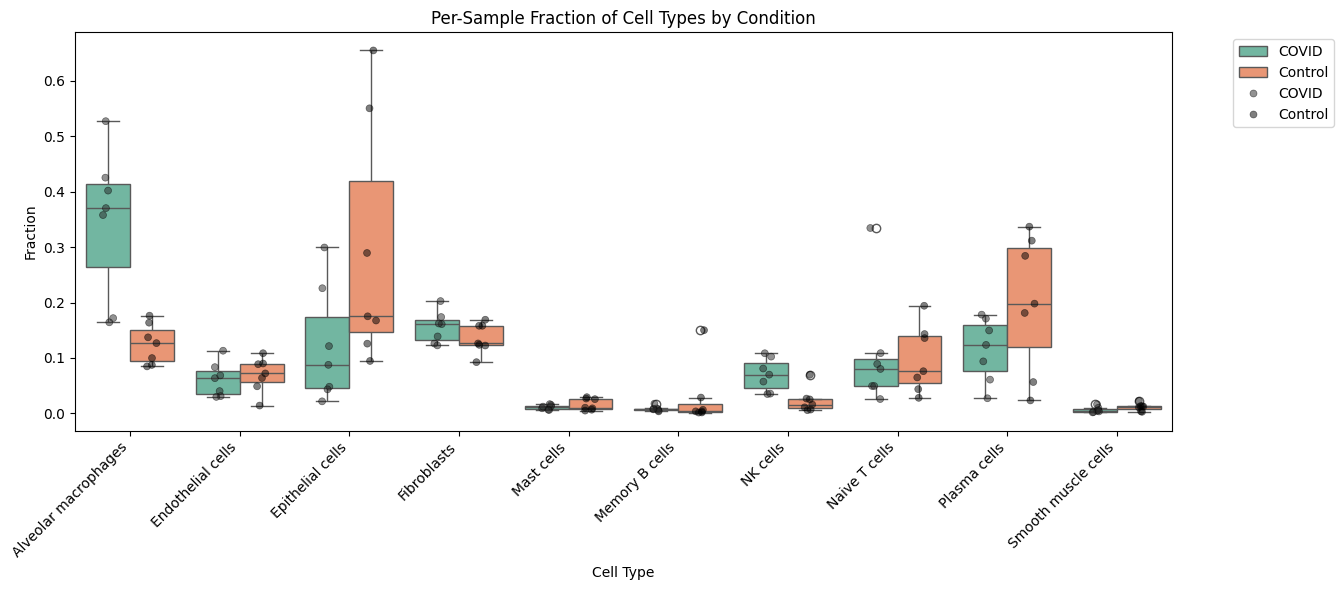

In [126]:
# Plot and save
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melt, x='cell_type', y='fraction', hue='condition', palette='Set2')
sns.stripplot(data=df_melt, x='cell_type', y='fraction', hue='condition', 
              dodge=True, alpha=0.5, color='black', linewidth=0.5)

plt.xticks(rotation=45, ha='right')
plt.title("Per-Sample Fraction of Cell Types by Condition")
plt.ylabel("Fraction")
plt.xlabel("Cell Type")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ✅ Save figure
plt.savefig("figures/boxplot_celltype_fractions_by_sample.png", dpi=300)
plt.show()

In [124]:
#Add statistical p-values (optional)
from scipy.stats import mannwhitneyu
# Calculate p-values per cell type
for ct in df_melt['cell_type'].unique():
    covid_vals = df_melt[(df_melt['cell_type'] == ct) & (df_melt['condition'] == 'COVID')]['fraction']
    ctrl_vals = df_melt[(df_melt['cell_type'] == ct) & (df_melt['condition'] == 'Control')]['fraction']
    stat, pval = mannwhitneyu(covid_vals, ctrl_vals, alternative='two-sided')
    print(f"{ct}: p = {pval:.4e}")

Alveolar macrophages: p = 2.3310e-03
Endothelial cells: p = 5.3497e-01
Epithelial cells: p = 7.2844e-02
Fibroblasts: p = 2.0862e-01
Mast cells: p = 8.0478e-01
Memory B cells: p = 3.8287e-01
NK cells: p = 4.0793e-03
Naive T cells: p = 9.0152e-01
Plasma cells: p = 1.6492e-01
Smooth muscle cells: p = 1.6492e-01


## Summary of Cell Type Proportion Analysis

We compared cell type distributions between COVID-19 and Control lungs using two complementary visualizations:

---

### 1. Grouped Bar Plot (Total Fractions)
**Figure**: `barplot_celltype_fractions.png`  
**Purpose**: Show total fraction of each cell type aggregated per condition.

**Key Insights**:
- **Alveolar macrophages** are **enriched** in COVID.
- **Epithelial** and **plasma cells** are relatively **depleted**.
- Offers a quick, intuitive summary of broad compositional shifts.

**Advantage**: Fast overview of trends.  
**Limitation**: Does not reflect sample-to-sample variability.

---

### 2. Boxplot with Points (Per-Sample Fractions)
**Figure**: `boxplot_celltype_fractions_by_sample.png`  
**Purpose**: Show the **distribution** of each cell type's abundance **across samples**.

**Key Insights**:
- Reveals **biological heterogeneity** (variation across patients).
- Allows **statistical testing** (such as Mann–Whitney U).

| Cell Type            | Trend in COVID | p-value  | Interpretation                                      |
|----------------------|----------------|----------|------------------------------------------------------|
| Alveolar macrophages | ↑ Enriched     | 0.0023   | Significant. Myeloid cell expansion.                 |
| NK cells             | ↑ Enriched     | 0.0041   | Significant. Active innate immune recruitment.       |
| Epithelial cells     | ↓ Depleted     | 0.0728   | Borderline depletion; barrier integrity affected.    |
| Plasma cells         | ↓ Depleted     | 0.165    | Mild reduction; not significant.                    |
| Endothelial cells    | ↓ Depleted     | 0.535    | No significant change.                              |
| Fibroblasts          | ≈ Same         | 0.208    | Not COVID-specific.                                 |
| Mast cells           | ≈ Same         | 0.804    | Stable population.                                  |
| Memory B cells       | ↓ Depleted     | 0.383    | Slight, not significant.                            |
| Naive T cells        | ≈ Same         | 0.901    | No differential recruitment.                        |
| Smooth muscle cells  | ↓ Depleted     | 0.165    | Possible structural impact.                         |


---

### Why This Matters
| Analysis Phase            | Contribution of These Plots                             |
|---------------------------|----------------------------------------------------------|
| **Annotation Validation** | Supports that identified cell types are biologically valid. |
| **Targeted DEGs**         | Focus DEG analysis on macrophages and NK cells.         |
| **Presentation**          | Boxplot preferred for figures; barplot for summaries.   |

---
#### The DEG analysis will Focus on **Alveolar macrophages** and **NK cells**, which show the most striking shifts. Avoid overanalyzing stable cell types.